# Анализ поведения пользователей мобильного приложения
## Заказчик

Стартап: мобильное приложение по продаже продуктов питания.

## Цель проекта

Необходимо проанализировать поведение покупателей на основании логов пользователей и результатов А/А/В - эксперимента (изменение шрифта во всем приложении).

## Входные данные

логи пользователей мабильного приложения (файл logs_exp.csv)
- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Ход исследования

Исследование пройдёт в четыре этапа:

- Обзор и предобработка данных;
- Анализ данных, воронка событий;
- Анализ результатов экспериента;
- Выводы.

## Общий план
Перед выполнением любой из задач, в первую очередь необходимо подготовить набор библиотек, познакомится с данными.

Сам процесс исследования будет проведен в следующем порядке (основные этапы):

    - загрузка библиотек и знакомство с данными
    - предобработка данных
    - формирование временных таблиц, включая новые сводные (если потребуется)
    - Анализ
    - Общие выводы по результатам

*Итоговая цель анализа* - оценка результатов текущего этапа тестирования.

## Подготовка, знакомство и предобработка 

In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy import stats as st
import datetime as dt
import seaborn as sns

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\s+')

In [3]:
display (data.head ())
display (data.info ())

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

In [4]:
data = data.rename(columns={'EventName':'event_name','DeviceIDHash':'user_id','EventTimestamp':'event_time','ExpId':'group'})
data['event_time'] = pd.to_datetime(data['event_time'], unit='s')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 7.5+ MB


In [5]:
data['date'] = data['event_time'].dt.date 
data['date'] = pd.to_datetime(data['date'])
data['time'] = data['event_time'].dt.time
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   event_time  244126 non-null  datetime64[ns]
 3   group       244126 non-null  int64         
 4   date        244126 non-null  datetime64[ns]
 5   time        244126 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


### Обработка пропусков и дубликатов

In [6]:
print (f' Явные дубликаты во всех строках и столбцах {data.duplicated ().sum ()}')
print ()
duplicates = data.duplicated()
duplicate_rows = data.loc[duplicates]
print(duplicate_rows.info())
print(duplicate_rows)

 Явные дубликаты во всех строках и столбцах 413

<class 'pandas.core.frame.DataFrame'>
Int64Index: 413 entries, 453 to 242635
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_name  413 non-null    object        
 1   user_id     413 non-null    int64         
 2   event_time  413 non-null    datetime64[ns]
 3   group       413 non-null    int64         
 4   date        413 non-null    datetime64[ns]
 5   time        413 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 22.6+ KB
None
                     event_name              user_id          event_time  \
453            MainScreenAppear  5613408041324010552 2019-07-30 08:19:44   
2350           CartScreenAppear  1694940645335807244 2019-07-31 21:51:39   
3573           MainScreenAppear   434103746454591587 2019-08-01 02:59:37   
4076           MainScreenAppear  3761373764179762633 2019-08-01 03:47:46   
480

In [7]:
data = data.drop_duplicates().reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_time  243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  datetime64[ns]
 5   time        243713 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(2)
memory usage: 11.2+ MB


In [8]:
display (data.isna ().sum ())

event_name    0
user_id       0
event_time    0
group         0
date          0
time          0
dtype: int64

По итогу предобработки пропусков невыявлено, все явный дубликаты удалены.

## Изучение и проверка данных
Проверим следующие вопросы:
-Сколько всего событий в логе?
-Сколько всего пользователей в логе?
-Сколько в среднем событий приходится на пользователя?
-Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?
-Много ли событий и пользователей вы потеряли, отбросив старые данные?
-Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [9]:
#Количество событий и пользователей в логе
display(data['event_name'].count(), data['event_name'].nunique())
display(data['user_id'].count(), data['user_id'].nunique())

243713

5

243713

7551

In [10]:
#Среднее количетсво событий пользователя
user_event = data.groupby('user_id').agg({'event_name' : 'count'}).mean ().round (1)
user_event

event_name    32.3
dtype: float64

In [11]:
#Изучим период для данных
data['event_time'].describe()

/tmp/ipykernel_48/3258294046.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data['event_time'].describe()


count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: event_time, dtype: object

Данные содержат информацию с 25/07/2019 по 07/08/2019.

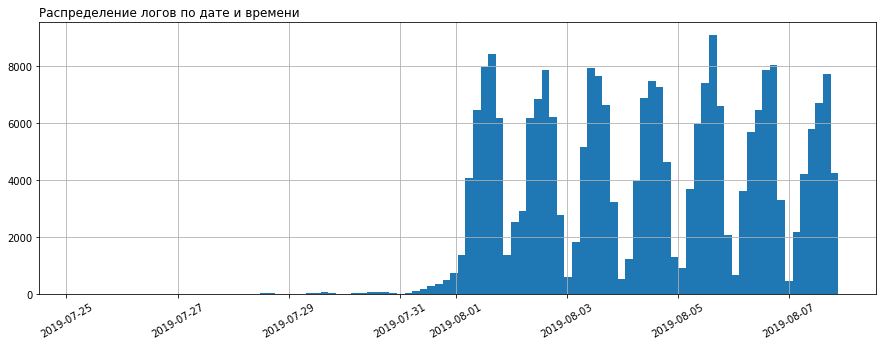

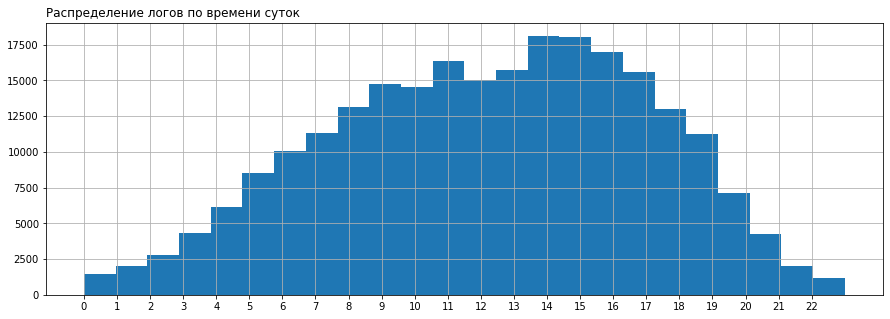

In [12]:
#Строим график распределения времени
plt.title('Распределение логов по дате и времени', loc='left')
data['event_time'].hist(bins=100, xrot=30,  figsize=(15, 5))
plt.show()

plt.title('Распределение логов по времени суток', loc='left')
data['event_time'].dt.hour.hist(bins=24, figsize=(15, 5))
plt.xticks(range(0, 23))
plt.show()

Данные за июль - неполные. Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные».
Поэтому, чтобы избежать данной проблемы, берем данные с 01-08-2019 по 07/08/2019. Так же, мы видим, что основная активность пользователей происходит в дневное время.

In [13]:
#Отбросим старые данные и оценим изменения
before_logs = data.shape[0]
before_users = data['user_id'].nunique()

print('ДО корректировки периода всего событий: %d, всего пользователей: %d.' % (before_logs, 
                                                                                before_users))
data = data[data['date'] >= '2019-08-01']
print()

print('ПОСЛЕ корректировки периода всего событий: %d, всего пользователей: %d.' % (data.shape[0], 
                                                                                   data['user_id'].nunique()))
print()

# diff: 

print('Изменение количества логов:', 
      data.shape[0]- before_logs, 
      '({:.1%})'.format((data.shape[0]-before_logs)/before_logs))
print('Изменение количества пользователей:', 
      data['user_id'].nunique()- before_users, 
      '({:.1%})'.format((data['user_id'].nunique()-before_users)/before_users))

ДО корректировки периода всего событий: 243713, всего пользователей: 7551.

ПОСЛЕ корректировки периода всего событий: 240887, всего пользователей: 7534.

Изменение количества логов: -2826 (-1.2%)
Изменение количества пользователей: -17 (-0.2%)


In [14]:
#Проверим, всё ли в порядке с группами
data.groupby('group').agg({'user_id': 'nunique','event_name':'count'})

,user_id,event_name
group,,
246,2484,79302
247,2513,77022
248,2537,84563


Количество пользователей в группах в общем и целом сопоставимо, количество событий немного разнится. Группа 248 имеет больше всего пользователей и событий.

## Изучите воронку событий
-Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
-Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
-Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
-По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.
-На каком шаге теряете больше всего пользователей?
-Какая доля пользователей доходит от первого события до оплаты?

In [15]:
#Проверим какие события есть и как часто они встречаются
events = (data.
          groupby('event_name').
          agg({'user_id': 'count'}).
          reset_index().
          rename(columns={'user_id' : 'total_events'}).
          sort_values(by='total_events', ascending=False))
events

,event_name,total_events
1,MainScreenAppear,117328
2,OffersScreenAppear,46333
0,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


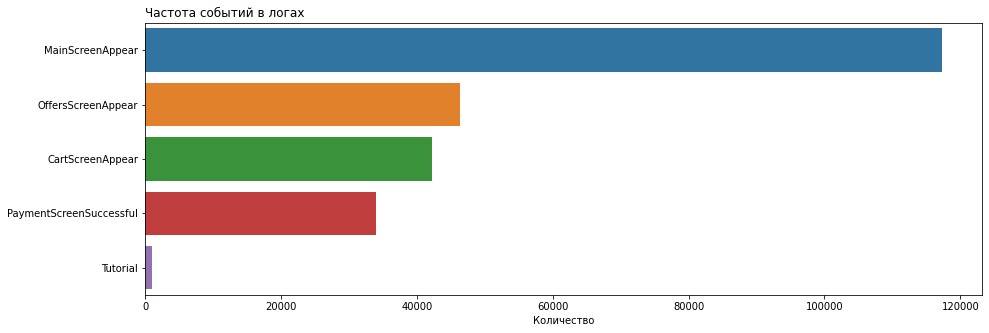

In [16]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='total_events', y='event_name', data=events)
ax.set_title('Частота событий в логах', loc='Left')
ax.set_xlabel('Количество') 
ax.set_ylabel('') 
plt.show()

MainScreenAppear (Главный экран) увидели 117328 раз;
OffersScreenAppear (Каталог предложений) увидели 46333 раза;
CartScreenAppear (Карточка товара) увидели 42303 раза;
PaymentScreenSuccessful (Экран с подтверждением успешной оплаты) увидели 33918 раз;
Tutorial (Урок) просмотрели 1005 раз.

In [17]:
#Отсортируем события по числу пользователей. Посчитаем долю пользователей, которые хоть раз совершали событие
users = (data.
          groupby('event_name').
          agg({'user_id': 'nunique'}).
          reset_index().
          rename(columns={'user_id' : 'total_users'}).
          sort_values(by='total_users', ascending=False))
users['percent'] = (users['total_users'] / data['user_id'].nunique() * 100).round(2)  
users


,event_name,total_users,percent
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


Главную страницу увидели 7419 пользователей (98.5% от общего числа пользователей) - почти все
Каталог предложений просмотрели 4593 пользователей (61% от общего числа)
Карточку товара 3734 пользователя (49.6% от общего числа)
Завершили оплату 3539 пользователей (47% от общего числа)
Урок просмотрели 840 пользователей (11% от общего числа)

Мы видим, что все события выстраиваются в цепочку действий, кроме просмотра урока (Tutorial). Для того, чтобы посмотреть урок (как пользоваться приложением?) не обязательно нужно что-то купить. Шаг Tutorial из дальнейшей цепочки уберем.

Тогда последовательность действий видится такой:
Главный экран
Каталог предложений
Карточка товара
Экран с подтверждением успешной оплаты

In [18]:
# считаем % по шагам (от предыдущего шага)


unit_event = data.pivot_table(
    index='event_name', 
    values='user_id',
    aggfunc=('nunique', 'count')).sort_values (by='count',ascending = False).reset_index()

display(unit_event)
unit_event = unit_event.rename(columns={'count':'users_count','nunique':'users_unique'})

for i, row in enumerate(unit_event.itertuples(), start=0):
    if i == 0:
        unit_event.at[row.Index, 'conv_step'] = 100
        unit_event.at[row.Index, 'conv_step_unique'] = 100
    else:
        prev_row = unit_event.iloc[i - 1]
        unit_event.at[row.Index, 'conv_step'] = (row.users_count / prev_row.users_count * 100).round(2)
        unit_event.at[row.Index, 'conv_step_unique'] = (row.users_unique / prev_row.users_unique * 100).round(2)
        
        
display(unit_event)



,event_name,count,nunique
0,MainScreenAppear,117328,7419
1,OffersScreenAppear,46333,4593
2,CartScreenAppear,42303,3734
3,PaymentScreenSuccessful,33918,3539
4,Tutorial,1005,840


,event_name,users_count,users_unique,conv_step,conv_step_unique
0,MainScreenAppear,117328,7419,100.00,100.00
1,OffersScreenAppear,46333,4593,39.49,61.91
2,CartScreenAppear,42303,3734,91.30,81.30
3,PaymentScreenSuccessful,33918,3539,80.18,94.78
4,Tutorial,1005,840,2.96,23.74


Мы видим, что наибольшее количество пользователей теряется после первого шага (более 38%). 

## Изучение результатов эксперимента

-Сколько пользователей в каждой экспериментальной группе?
-Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.
-Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?
-Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
-Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.

In [19]:
#Общее количество пользователей в каждой группе
data_grouped = data.groupby('group')['user_id'].agg('nunique')
data_grouped

group
246    2484
247    2513
248    2537
Name: user_id, dtype: int64

In [20]:
#Распределим участников в каждой группе по этапам прохождения воронки
data = data[data['event_name'] != 'Tutorial']

table = data.pivot_table(index='group',columns='event_name', values='user_id', aggfunc='nunique').reset_index()
table['user_count'] = table['group'].apply(lambda x: data_grouped.loc[x])
table = table.set_index('group')

groups = table.loc[246] + table.loc[247]
groups.name = '246_247'
table = table.append([groups])
table = table.reindex([246, 247, '246_247', 248])
table.info()
display(table)
display(table.columns)

<class 'pandas.core.frame.DataFrame'>
Index: 4 entries, 246 to 248
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   CartScreenAppear         4 non-null      int64
 1   MainScreenAppear         4 non-null      int64
 2   OffersScreenAppear       4 non-null      int64
 3   PaymentScreenSuccessful  4 non-null      int64
 4   user_count               4 non-null      int64
dtypes: int64(5)
memory usage: 192.0+ bytes


event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,user_count
246,1266,2450,1542,1200,2484
247,1238,2476,1520,1158,2513
246_247,2504,4926,3062,2358,4997
248,1230,2493,1531,1181,2537


Index(['CartScreenAppear', 'MainScreenAppear', 'OffersScreenAppear',
       'PaymentScreenSuccessful', 'user_count'],
      dtype='object', name='event_name')

In [21]:
#Напишем функцию для проверки статистической значимости
#Фнукция принимает на входе 4 значения с логами и проверяет есть ли стат разница между долями пользователей 

def z_test(nusers1, nusers2, success1, success2, alpha):
 
    # пропорции успехов в группах:
    p1 = success1/nusers1
    p2 = success2/nusers2
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (success1 + success2) / (nusers1 + nusers2)

    # разница пропорций в датасетах
    difference = p1 - p2 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference /  np.sqrt(p_combined * (1 - p_combined) * (1/nusers1 + 1/nusers2))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    
    print('p-значение: ', p_value.round(4))

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

Согласно предложенному процессу, нам нужно будет сопоставить доли по каждому событию между:
-контрольными группами 246 и 247;
-каждой из контрольной группы по отдельности и экспериментальной (246-248 и 247-248);
-объединенной контрольной группой и экспериментальной (246+247 и 248).

Введём гипотезы.
Н0: доли уникальных посетителей, попавших на этап воронки, одинаковы.
Н1: доли уникальных посетителей, попавших на этап воронки, отличаются.

In [22]:
# проверим, есть ли статистически значимая разница между контрольными группами 246 и 247:
group1 = 246
group2 = 247
for event in range(4):
        curr_event = table.columns[event]
        print('Событие:', curr_event)
        z_test(table['user_count'][group1],table['user_count'][group2],table[curr_event][group1],table[curr_event][group2],.01)
   

Событие: CartScreenAppear
p-значение:  0.2288
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: MainScreenAppear
p-значение:  0.7571
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: OffersScreenAppear
p-значение:  0.2481
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: PaymentScreenSuccessful
p-значение:  0.1146
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Между группами 246 и 247 ни по одному событию нет статистически достоверного отличия при заданном уровне значимости, а значит, приступаем к A/B-тестированию.

In [23]:
# проверим, есть ли статистически значимая разница между всеми группами:
for i in range(3):
    group1 = table.index[i]
    group2 = 248
    print()
    print(f'Сравнение групп {group1} и {group2}.')
    for event in range(4):
        curr_event = table.columns[event]
        print('Событие:', curr_event)
        z_test(table['user_count'][group1],table['user_count'][group2],table[curr_event][group1],table[curr_event][group2],.01)


Сравнение групп 246 и 248.
Событие: CartScreenAppear
p-значение:  0.0784
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: MainScreenAppear
p-значение:  0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: OffersScreenAppear
p-значение:  0.2084
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: PaymentScreenSuccessful
p-значение:  0.2123
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Сравнение групп 247 и 248.
Событие: CartScreenAppear
p-значение:  0.5786
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: MainScreenAppear
p-значение:  0.4587
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: OffersScreenAppear
p-значение:  0.9198
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Событие: PaymentScreenSuccessful
p-значение:  0.7373
Не получилось

Фиксируем, что изменение шрифтов во всём приложении на поведение пользователей не повлияло. Статистически значимой разницы мы не обнаружили.


## Вывод
В результате исследования были проанализированы поведение покупателей на основании логов пользователей, а так же, результаты А/А/В-теста. После предобработки данных было рассмотрено поведение 7419-ти пользователей мобильного приложения.

Было выявлено, что:

Главную страницу увидели 7419 пользователей (100% от общего числа пользователей);
Страницу товара просмотрели 4593 пользователей (61% от общего числа);
Карточку просмотрели 3734 пользователя (50% от общего числа);
Завершили оплату 3539 пользователей (47% от общего числа).
Еще одно событие (Tutorial) было исключено из анализа ввиду необязательного прохождения и отсутствия влияния на остальные шаги.

Большее количество пользователей приложение теряло после первого шага (более 38%).
Был проанализирован результат А/А/В-эксперимента(изменение шрифта во всем приложении), для этого были ипользованы логи событий за неделю (с 01/08/2019 по 07/08/2019).

В эксперименте были учтено поведение пользователей, разделенных на три группы:

246-ая - 2484 пользователя;
247-ая - 2513 пользователя;
248-ая - 2537 пользователя.
Согласно предложенному процессу, нам нужно было сопоставить доли пользователей по каждому событию между:
-контрольными группами 246 и 247;
-каждой из контрольной группы по отдельности и экспериментальной (246-248 и 247-248);
-объединенной контрольной группой и экспериментальной (246+247 и 248).

Множесто А/В-тестов, проведённых по каждому из событий, не обнаружили статистически значимой разницы между группами. Т.е. изменение шрифтов во всём приложении на поведение пользователей не повлияло.
Однако стоит учитывать, что вероятность ни разу не ошибиться при 16 тестах равна: (1-0.99)^16 = 0.85, это довольно высокий показатель.